In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import pybrain as pb
import matplotlib.pyplot as plt

#volume needed
volume = list(range(0,100000, 1))

#This script tells you how many shares you need to purchase to dilute a loss
def dilute_losses(initial_volume, initial_price, current_price):
    ### Inputs and outputs
    #param initial_volume: the initial number of shares purchased
    #param initial_price: the inital price paid per share
    #param current_price: the current stock price
    #output: the number of shares needed to dilute the price and how much that would cost
    ###
    for i in volume:
        a = ((i * current_price) + (initial_volume * initial_price)) / (i + initial_volume)
        if a < (current_price + 0.01):
            print(i, 'new shares at a price of $', current_price, 'need to be purchased to mostly dilute your losses. This will cost roughly $',int(i * current_price))
            break
           

In [ ]:
dilute_losses(100,0.3428,.2389)

In [ ]:
#This script tells you the price per share to obtain a desired value
def new_price(initial_volume, initial_price, desired_value):
    ### Inputs and outputs
    #param initial_volume: the initial number of shares purchased
    #param initial_price: the inital price paid per share
    #param desired_value: the desired value of your holding
    #output: the stock price needed to achieve a given value and how much a stock needs to go up
    ###
    current_value = initial_volume * initial_price
    new_price = desired_value / initial_volume
    print('To obtain a desired value of $', desired_value, 'the price needs to go up to $', new_price, 'a change of $',
         new_price - initial_price)

In [ ]:
new_price(100, 0.5, 100)
new_price(100, 0.5, 200)

In [ ]:
#This script tells you how much of your profit needs to go to taxes, reinvestment, and savings
def distribution_of_profits(profit):
    print('$', profit * 0.4, 'needs to go to taxes')
    print('$', profit * 0.3, 'needs to go to reinvestment')
    print('$', profit * 0.3, 'needs to go to savings')

In [ ]:
distribution_of_profits(100)

In [1]:
#Connecting to yFinance and create a ticker dataframe
def create_ticker_df(ticker_symbols, start_date, end_date):
    """" Inputs and outputs
    #param ticker_symbols: a single or list of ticker symbols
    #param start_date: date in YYYY-M-D
    #param end_date: date in YYYY-M-D
    #output dataframe
    """
    ticker_df = []
    for i in ticker_symbols:
        temp_tick = yf.Ticker(i)
        temp_df = temp_tick.history(period='1d', start=start_date, end=end_date)
        temp_df['ticker'] = i
        temp_df['daily_change'] = temp_df['Close'] - temp_df['Open']
        temp_df['change_over_volume'] = temp_df['daily_change'] / temp_df['Volume']
        temp_df['change'] = np.where(temp_df['daily_change'] >= 0, 'increase', 'decrease')
        ticker_df.append(temp_df)
    ticker_df = pd.concat(ticker_df, axis=0)
    return(ticker_df)

In [ ]:
create_ticker_df(['TPIC','F'],'2020-4-1','2020-5-08').head()

In [48]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
import plotly.graph_objects as go

def make_estimates(ticker_symbol, epos, metric = 'Close', look_back = 5, look_forward = 10, start_date = '2019-5-1', end_date = '2020-5-17'):
    temp_df = create_ticker_df([ticker_symbol], start_date, end_date)
    df = temp_df.copy()
    df['Date'] = df.index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_axis(df['Date'], inplace=True)
    df = df[['Date', metric]]
    close_data = df['Close'].values
    close_data = close_data.reshape((-1,1))
    split_percent = 0.70
    split = int(split_percent*len(close_data))
    min_max_scaler = MinMaxScaler()
    close_train =  min_max_scaler.fit_transform(close_data[:split])
    close_test =  min_max_scaler.fit_transform(close_data[split:])
    date_train = df['Date'][:split]
    date_test = df['Date'][split:]
    train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
    test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)
    model = Sequential()
    model.add(
        LSTM(10,
            activation='relu',
            input_shape=(look_back,1))
    )
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    num_epochs = epos
    model.fit_generator(train_generator, epochs=num_epochs, verbose=0)
    prediction = model.predict_generator(test_generator)
    close_train = close_train.reshape((-1))
    close_test = close_test.reshape((-1))
    prediction = model.predict_generator(test_generator)
    close_train = close_train.reshape((-1))
    close_test = close_test.reshape((-1))
    prediction = prediction.reshape((-1))

    trace1 = go.Scatter(
        x = date_train,
        y = close_train,
        mode = 'lines',
        name = 'Data'
    )
    trace2 = go.Scatter(
        x = date_test,
        y = prediction,
        mode = 'lines',
        name = 'Prediction'
    )
    trace3 = go.Scatter(
        x = date_test,
        y = close_test,
        mode='lines',
        name = 'Ground Truth'
    )
    layout = go.Layout(
        title = ticker_symbol,
        xaxis = {'title' : "Date"},
        yaxis = {'title' : "Close"}
    )
    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    fig.show()
    close_data = close_data.reshape((-1))

    def predict(num_prediction, model):
        prediction_list = close_data[-look_back:]

        for _ in range(num_prediction):
            x = prediction_list[-look_back:]
            x = x.reshape((1, look_back, 1))
            out = model.predict(x)[0][0]
            prediction_list = np.append(prediction_list, out)
        prediction_list = prediction_list[look_back-1:]

        return prediction_list

    def predict_dates(num_prediction):
        last_date = df['Date'].values[-1]
        prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
        return prediction_dates

    num_prediction = 10
    forecast = predict(num_prediction, model)
    forecast_dates = predict_dates(num_prediction)
    out_frame = []
    q = {'dates':forecast_dates,'price':forecast}
    out_temp = pd.DataFrame(q)
    out_frame.append(out_temp)
    out_frame = pd.concat(out_frame, axis=0)
    out_frame['ticker'] = ticker_symbol
    plt.plot(out_frame['price'])
    plt.xlabel('days from now (5/15/20)')
    plt.ylabel('estimated stock price')
    return(out_frame)


,dates,price,ticker
0,2020-05-18,0.360000,FET
1,2020-05-19,0.371696,FET
2,2020-05-20,0.381164,FET
3,2020-05-21,0.388876,FET
4,2020-05-22,0.395190,FET
5,2020-05-23,0.400382,FET
6,2020-05-24,0.404665,FET
7,2020-05-25,0.408208,FET
8,2020-05-26,0.411146,FET
9,2020-05-27,0.413587,FET


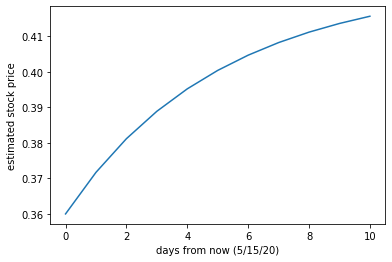

In [50]:
make_estimates(ticker_symbol = 'FET', epos = 100, start_date = '2020-03-19', end_date = '2020-5-19', look_back = 1)

[        dates     price ticker
 0  2020-05-18  0.898300   MVIS
 1  2020-05-19  0.726853   MVIS
 2  2020-05-20  0.726853   MVIS
 3  2020-05-21  0.726853   MVIS
 4  2020-05-22  0.726853   MVIS
 5  2020-05-23  0.726853   MVIS
 6  2020-05-24  0.726853   MVIS
 7  2020-05-25  0.726853   MVIS
 8  2020-05-26  0.726853   MVIS
 9  2020-05-27  0.726853   MVIS
 10 2020-05-28  0.726853   MVIS,
         dates     price ticker
 0  2020-05-18  0.570100    ASM
 1  2020-05-19  0.571338    ASM
 2  2020-05-20  0.578392    ASM
 3  2020-05-21  0.586506    ASM
 4  2020-05-22  0.591191    ASM
 5  2020-05-23  0.594903    ASM
 6  2020-05-24  0.598574    ASM
 7  2020-05-25  0.602008    ASM
 8  2020-05-26  0.605239    ASM
 9  2020-05-27  0.608358    ASM
 10 2020-05-28  0.611385    ASM,
         dates     price ticker
 0  2020-05-18  1.340000   UAVS
 1  2020-05-19  0.770940   UAVS
 2  2020-05-20 -0.034471   UAVS
 3  2020-05-21 -0.977832   UAVS
 4  2020-05-22 -1.302233   UAVS
 5  2020-05-23 -0.805774   UAVS
 6  20

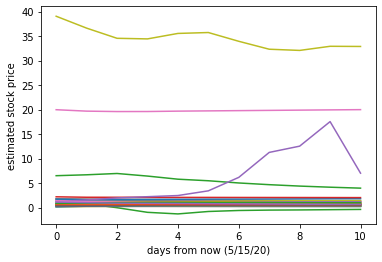

In [9]:
ticker_syms = ['MVIS', 'ASM', 'UAVS', 'KTOV', 'IZEA', 'MARK',
               'GNUS', 'IBIO', 'FET', 'AUMN', 'XSPA', 'RNWK', 'SRNE', 'RTTR', 'CBL', 'ZOM',
              'TPIC','TTNP','FSLY','VISL', 'KOS', 'BIOC', 'MARA', 'RIOT', 'INPX', 'OCGN', 
              'CEI', 'EMAN', 'SHIP', 'TAT', 'TOPS', 'RMBL', 'FRSX', 'HTGM', 'DFFN', 'ONTX']

#ticker_syms = ['MVIS', 'KTOV', 'FET', 'MARK', 'TOPS', 'SHIP', 'TAT', 'ZOM', 'CBL']    
out_df = []

for i in ticker_syms:
    blanko = []
    blanko = make_estimates(ticker_symbol = i, epos = 2500, start_date = '2019-5-1', end_date = '2020-5-19')
    out_df.append(blanko)
out_df

In [10]:
df2 = pd.concat(out_df)

df2.to_csv('Predictions_05_18_20_v2.csv')